In [ ]:
# change working directory
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
# from pycaret import classification
import pycaret
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, recall_score, precision_score, f1_score, get_scorer, make_scorer # to define own metrics
from pycaret.classification import *
import shap
from imblearn.over_sampling import RandomOverSampler

# Load the datasets
train_path = '/content/drive/MyDrive/PROIECTAI/job_change_train.csv'
test_path = '/content/drive/MyDrive/PROIECTAI/job_change_test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Display the first few rows of each dataset
train_data_info = train_data.head(), train_data.info()
test_data_info = test_data.head(), test_data.info()

train_data_info, test_data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12427 entries, 0 to 12426
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      12427 non-null  int64  
 1   gender                  12427 non-null  object 
 2   age                     12427 non-null  int64  
 3   education               12427 non-null  object 
 4   field_of_studies        12427 non-null  object 
 5   is_studying             12427 non-null  object 
 6   county                  12427 non-null  object 
 7   relative_wage           12427 non-null  float64
 8   years_since_job_change  12427 non-null  object 
 9   years_of_experience     12427 non-null  object 
 10  hours_of_training       12427 non-null  int64  
 11  is_certified            12427 non-null  int64  
 12  size_of_company         12427 non-null  object 
 13  type_of_company         12427 non-null  object 
 14  willing_to_change_job   12427 non-null

((   id   gender  age   education field_of_studies is_studying      county  \
  0   1     Male   22  higher_BSc          science          no  county_118   
  1   2     Male   27  higher_BSc          science          no  county_028   
  2   3     Male   38  higher_BSc          science          no  county_031   
  3   4  Unknown   47  higher_BSc          science          no  county_080   
  4   5     Male   28  higher_BSc          science          no  county_118   
  
     relative_wage years_since_job_change years_of_experience  \
  0         162.84                      1                   2   
  1         151.34                      1                   6   
  2         114.17                      1                  13   
  3         123.55                     >4                 >20   
  4         162.84                      1                   5   
  
     hours_of_training  is_certified size_of_company       type_of_company  \
  0                 18             1             <10      

In [ ]:
# Checking for missing values in the training data
missing_summary_train = train_data.isnull().sum()

# Checking unique values in key columns to identify categorical variables and ranges
categorical_columns = train_data.select_dtypes(include=['object']).columns
unique_values_summary = {col: train_data[col].unique() for col in categorical_columns}

# Summarizing the target variable distribution for class balance
target_distribution = train_data['willing_to_change_job'].value_counts(normalize=True)

# Display findings
missing_summary_train, unique_values_summary, target_distribution

(id                        0
 gender                    0
 age                       0
 education                 0
 field_of_studies          0
 is_studying               0
 county                    0
 relative_wage             0
 years_since_job_change    0
 years_of_experience       0
 hours_of_training         0
 is_certified              0
 size_of_company           0
 type_of_company           0
 willing_to_change_job     0
 dtype: int64,
 {'gender': array(['Male', 'Unknown', 'Female', 'Other'], dtype=object),
  'education': array(['higher_BSc', 'secondary', 'higher_MSc', 'Phd', 'primary',
         'no_information'], dtype=object),
  'field_of_studies': array(['science', 'no_information', 'other', 'humanities', 'business',
         'arts'], dtype=object),
  'is_studying': array(['no', 'full_time', 'part_time', 'no_information'], dtype=object),
  'county': array(['county_118', 'county_028', 'county_031', 'county_080',
         'county_059', 'county_117', 'county_074', 'county_049

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode the target variable
train_data['willing_to_change_job'] = train_data['willing_to_change_job'].map({'No': 0, 'Yes': 1})

# Step 2: Transform "years_since_job_change"
# Mapping ranges and values
years_since_job_change_map = {
    'never_changed': -1,  # Special case for never changed jobs
    'unknown': -2,        # Treat unknown separately
    '>4': 5,              # Encode '>4' as 5
    '1': 1, '2': 2, '3': 3, '4': 4
}
train_data['years_since_job_change'] = train_data['years_since_job_change'].map(years_since_job_change_map)
test_data['years_since_job_change'] = test_data['years_since_job_change'].map(years_since_job_change_map)

# Step 3: Transform "years_of_experience"
# Mapping ranges and values
years_of_experience_map = {
    '<1': 0.5,  # Encode "<1" as 0.5
    '>20': 21,  # Encode ">20" as 21
    'unknown': -2  # Treat unknown separately
}
# Keep numeric values as-is
train_data['years_of_experience'] = train_data['years_of_experience'].replace(years_of_experience_map).astype(float)
test_data['years_of_experience'] = test_data['years_of_experience'].replace(years_of_experience_map).astype(float)

# Step 4: Check transformations and data readiness
train_data.head(), test_data.head()

(   id   gender  age   education field_of_studies is_studying      county  \
 0   1     Male   22  higher_BSc          science          no  county_118   
 1   2     Male   27  higher_BSc          science          no  county_028   
 2   3     Male   38  higher_BSc          science          no  county_031   
 3   4  Unknown   47  higher_BSc          science          no  county_080   
 4   5     Male   28  higher_BSc          science          no  county_118   
 
    relative_wage  years_since_job_change  years_of_experience  \
 0         162.84                       1                  2.0   
 1         151.34                       1                  6.0   
 2         114.17                       1                 13.0   
 3         123.55                       5                 21.0   
 4         162.84                       1                  5.0   
 
    hours_of_training  is_certified size_of_company       type_of_company  \
 0                 18             1             <10       pri

In [ ]:
!pip install pycaret[analysis]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 38.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 16.6 MB/s eta 0:00:00
   

In [ ]:
from pycaret.classification import *
from imblearn.over_sampling import RandomOverSampler # Import RandomOverSampler

# Setting up the PyCaret environment with the training data
pycaret_setup = setup(
    data=train_data,
    target='willing_to_change_job',
    normalize=True,
    normalize_method='minmax',
    fix_imbalance=True,  # Addressing class imbalance
    fix_imbalance_method=RandomOverSampler(random_state=123),
    session_id=123,  # For reproducibility
    ignore_features=['id'],  # Exclude ID column from modeling
    categorical_imputation='constant',  # Handle "unknown" categories
    numeric_imputation='knn',  # Handle any potential missing numeric values
    ordinal_features={  # Define ordinal relationships
        'years_since_job_change': [-2, -1, 1, 2, 3, 4, 5],
        'years_of_experience': [-2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
    }
)

,Description,Value
0,Session id,123
1,Target,willing_to_change_job
2,Target type,Binary
3,Original data shape,"(12427, 15)"
4,Transformed data shape,"(16803, 44)"
5,Transformed train set shape,"(13074, 44)"
6,Transformed test set shape,"(3729, 44)"
7,Ignore features,1
8,Ordinal features,2
9,Numeric features,6


In [ ]:
# Compare models using PyCaret's compare_models() function
# This will evaluate multiple algorithms and sort them by 'Accuracy' (or other metrics like 'AUC')
best_models = compare_models(sort='Accuracy', n_select=5)  # Select the top 5 models based on Accuracy

# Display the best models
best_models


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7916,0.7984,0.5932,0.5784,0.5854,0.4463,0.4466,1.9390
lightgbm,Light Gradient Boosting Machine,0.7851,0.7991,0.7196,0.5521,0.6245,0.4777,0.4862,1.8290
et,Extra Trees Classifier,0.7783,0.7847,0.4517,0.5676,0.5025,0.3625,0.3666,1.9910
gbc,Gradient Boosting Classifier,0.7775,0.8092,0.7432,0.5381,0.6240,0.4718,0.4844,2.0580
lda,Linear Discriminant Analysis,0.7757,0.8052,0.7510,0.5348,0.6245,0.4710,0.4851,0.3210
ridge,Ridge Classifier,0.7754,0.8053,0.7510,0.5343,0.6241,0.4704,0.4845,0.3440
lr,Logistic Regression,0.7722,0.8051,0.7547,0.5293,0.6220,0.4662,0.4815,1.1360
ada,Ada Boost Classifier,0.7659,0.7999,0.7510,0.5201,0.6144,0.4543,0.4702,1.1070
svm,SVM - Linear Kernel,0.7563,0.8021,0.7547,0.5068,0.6058,0.4392,0.4582,0.7010
dummy,Dummy Classifier,0.7516,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2820


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        monotonic_cst=None, n_estimators=100, n_jobs=-1,
                        oob_score=False, random_state=123, verbose=0,
                        warm_start=False),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),


In [ ]:
# Step 1: Categorical Encoding
# Define columns to be one-hot encoded and ordinally encoded (already handled earlier)
categorical_features = ['gender', 'education', 'field_of_studies', 'is_studying',
                        'county', 'type_of_company']

# Step 2: Handle "unknown" or similar placeholders
# Replace 'unknown' with NaN for easier imputation
train_data.replace('unknown', pd.NA, inplace=True)
test_data.replace('unknown', pd.NA, inplace=True)

# Impute missing values
train_data.fillna({
    'gender': 'Other',  # Replace missing gender with 'Other'
    'field_of_studies': 'no_information',  # Assume no information category
    'education': 'no_information',  # Handle unknown education similarly
    'is_studying': 'no_information'  # No studying information
}, inplace=True)

test_data.fillna({
    'gender': 'Other',
    'field_of_studies': 'no_information',
    'education': 'no_information',
    'is_studying': 'no_information'
}, inplace=True)

# Numeric imputations for any missing numeric features
numeric_features = ['relative_wage', 'hours_of_training']
for col in numeric_features:
    train_data[col].fillna(train_data[col].median(), inplace=True)
    test_data[col].fillna(test_data[col].median(), inplace=True)

# Step 3: Verify changes
train_data.head(), test_data.head()


(   id   gender  age   education field_of_studies is_studying      county  \
 0   1     Male   22  higher_BSc          science          no  county_118   
 1   2     Male   27  higher_BSc          science          no  county_028   
 2   3     Male   38  higher_BSc          science          no  county_031   
 3   4  Unknown   47  higher_BSc          science          no  county_080   
 4   5     Male   28  higher_BSc          science          no  county_118   
 
    relative_wage  years_since_job_change  years_of_experience  \
 0         162.84                       1                  2.0   
 1         151.34                       1                  6.0   
 2         114.17                       1                 13.0   
 3         123.55                       5                 21.0   
 4         162.84                       1                  5.0   
 
    hours_of_training  is_certified size_of_company       type_of_company  \
 0                 18             1             <10       pri

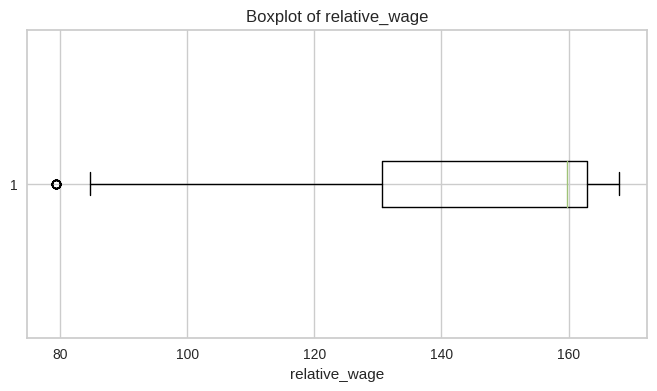

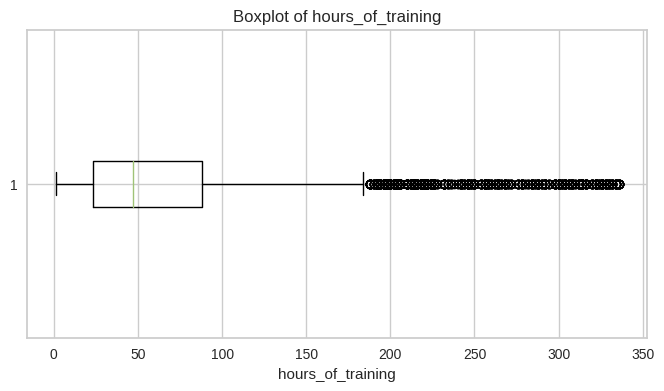

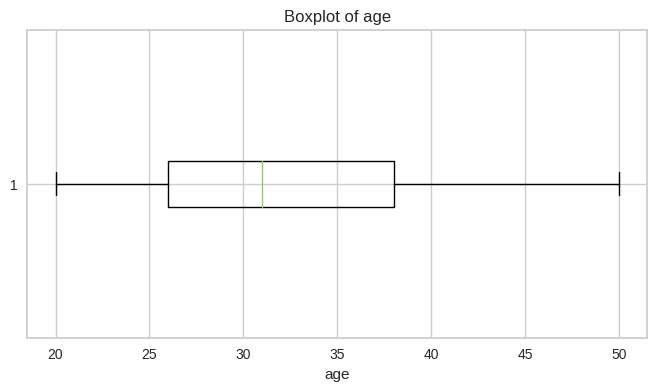

{'relative_wage': (82.31499999999998, 211.15500000000003),
 'hours_of_training': (-74.5, 185.5),
 'age': (8.0, 56.0)}

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Visualize numeric features for outliers
numeric_features = ['relative_wage', 'hours_of_training', 'age']

# Plot boxplots for the numeric features
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    plt.boxplot(train_data[col], vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

# Step 2: Identify potential outliers using IQR (Interquartile Range)
outlier_bounds = {}
for col in numeric_features:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_bounds[col] = (lower_bound, upper_bound)

outlier_bounds


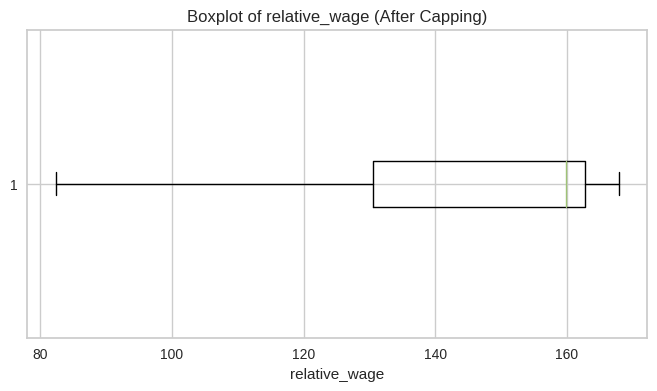

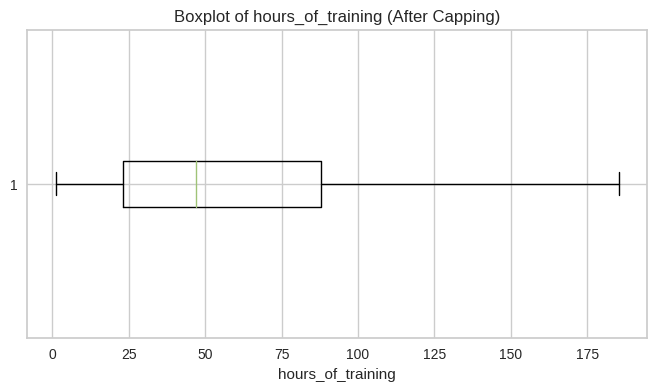

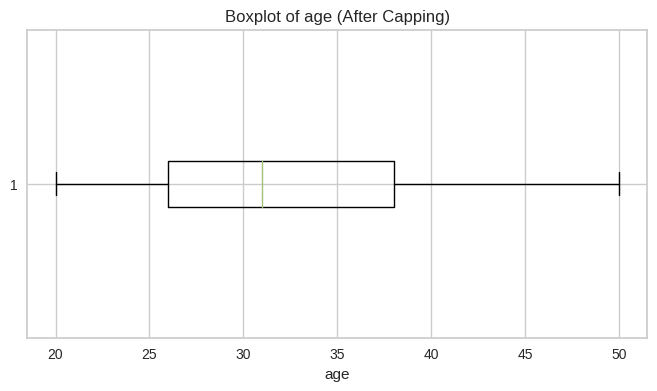

,relative_wage,hours_of_training,age
count,12427.000000,12427.000000,12427.000000
mean,146.559909,61.781926,32.844130
std,21.953708,50.158316,8.164951
min,82.315000,1.000000,20.000000
25%,130.630000,23.000000,26.000000
50%,159.830000,47.000000,31.000000
75%,162.840000,88.000000,38.000000
max,167.970000,185.500000,50.000000


In [ ]:
# Step 1: Cap outliers at lower and upper bounds
for col, bounds in outlier_bounds.items():
    lower, upper = bounds
    # Apply capping for training data
    train_data[col] = train_data[col].clip(lower=lower, upper=upper)
    # Apply capping for test data
    test_data[col] = test_data[col].clip(lower=lower, upper=upper)

# Step 2: Verify the changes with updated boxplots
for col in numeric_features:
    plt.figure(figsize=(8, 4))
    plt.boxplot(train_data[col], vert=False)
    plt.title(f'Boxplot of {col} (After Capping)')
    plt.xlabel(col)
    plt.show()

# Display updated summary for numeric columns
train_data[numeric_features].describe()


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Step 1: Separate features and target
X_train = train_data.drop(columns=['willing_to_change_job', 'id'])  # Features
y_train = train_data['willing_to_change_job']  # Target

# Step 2: Apply Random Oversampling
ros = RandomOverSampler(random_state=123)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

# Step 3: Check the new class distribution
balanced_class_distribution = y_train_balanced.value_counts(normalize=True)

# Display the updated distribution
balanced_class_distribution


,proportion
willing_to_change_job,
0,0.5
1,0.5


In [ ]:
# Import necessary components
from pycaret.classification import setup, compare_models

# Combine balanced features and target into a single DataFrame
balanced_data = X_train_balanced.copy()
balanced_data['willing_to_change_job'] = y_train_balanced

# Initialize PyCaret with balanced data
pycaret_setup_balanced = setup(
    data=balanced_data,
    target='willing_to_change_job',
    normalize=True,
    normalize_method='minmax',
    fold=5,  # 5-fold cross-validation
    session_id=123  # For reproducibility
)

# Compare models
best_models_balanced = compare_models(sort='Accuracy', n_select=5)



,Description,Value
0,Session id,123
1,Target,willing_to_change_job
2,Target type,Binary
3,Original data shape,"(18680, 14)"
4,Transformed data shape,"(18680, 43)"
5,Transformed train set shape,"(13076, 43)"
6,Transformed test set shape,"(5604, 43)"
7,Numeric features,6
8,Categorical features,7
9,Rows with missing values,37.1%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8796,0.9554,0.9153,0.8544,0.8838,0.7593,0.7613,2.2880
rf,Random Forest Classifier,0.8783,0.9438,0.9296,0.8431,0.8843,0.7567,0.7607,1.5520
dt,Decision Tree Classifier,0.8323,0.8327,0.9052,0.7901,0.8437,0.6646,0.6718,0.3940
lightgbm,Light Gradient Boosting Machine,0.8015,0.8602,0.8073,0.7980,0.8026,0.6029,0.6030,1.9140
gbc,Gradient Boosting Classifier,0.7737,0.8232,0.7635,0.7795,0.7714,0.5474,0.5476,1.5980
ada,Ada Boost Classifier,0.7618,0.8028,0.7541,0.7660,0.7599,0.5236,0.5236,1.2680
lr,Logistic Regression,0.7606,0.8036,0.7612,0.7602,0.7607,0.5211,0.5211,2.0640
ridge,Ridge Classifier,0.7604,0.8031,0.7559,0.7628,0.7593,0.5208,0.5208,0.4220
lda,Linear Discriminant Analysis,0.7604,0.8031,0.7559,0.7628,0.7593,0.5208,0.5208,0.3400
svm,SVM - Linear Kernel,0.7503,0.7988,0.6990,0.7793,0.7365,0.5006,0.5037,0.6640


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
# Import necessary functions
from pycaret.classification import create_model, tune_model

# Step 1: Create the base models
et_model = create_model('et')  # Extra Trees Classifier
rf_model = create_model('rf')  # Random Forest Classifier

# Step 2: Tune the created models
tuned_et = tune_model(et_model, optimize='Accuracy')  # Tune Extra Trees
tuned_rf = tune_model(rf_model, optimize='Accuracy')  # Tune Random Forest

# Display the tuned models
print("Tuned Extra Trees Classifier:")
print(tuned_et)

print("\nTuned Random Forest Classifier:")
print(tuned_rf)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8781,0.9506,0.9106,0.8550,0.8819,0.7561,0.7577
1,0.8830,0.9582,0.9205,0.8563,0.8873,0.7660,0.7681
2,0.8841,0.9597,0.9258,0.8546,0.8888,0.7683,0.7709
3,0.8746,0.9549,0.9166,0.8454,0.8796,0.7491,0.7518
4,0.8784,0.9538,0.9028,0.8607,0.8813,0.7568,0.7577
Mean,0.8796,0.9554,0.9153,0.8544,0.8838,0.7593,0.7613
Std,0.0035,0.0032,0.0080,0.0050,0.0036,0.0070,0.0071


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8742,0.9413,0.9213,0.8421,0.8799,0.7485,0.7518
1,0.8834,0.9447,0.9381,0.8456,0.8895,0.7667,0.7713
2,0.8857,0.9521,0.9411,0.8472,0.8917,0.7713,0.7761
3,0.8723,0.9398,0.9243,0.8371,0.8785,0.7446,0.7486
4,0.8761,0.9413,0.9235,0.8435,0.8817,0.7522,0.7556
Mean,0.8783,0.9438,0.9296,0.8431,0.8843,0.7567,0.7607
Std,0.0052,0.0044,0.0083,0.0035,0.0053,0.0105,0.0110


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7737,0.8203,0.7531,0.7855,0.7689,0.5474,0.5479
1,0.7774,0.8229,0.7661,0.7840,0.7749,0.5549,0.5550
2,0.7748,0.8250,0.7492,0.7897,0.7689,0.5495,0.5503
3,0.7717,0.8117,0.7552,0.7809,0.7678,0.5434,0.5437
4,0.7671,0.8137,0.7368,0.7842,0.7598,0.5342,0.5352
Mean,0.7729,0.8187,0.7521,0.7849,0.7681,0.5459,0.5464
Std,0.0035,0.0052,0.0095,0.0029,0.0049,0.0069,0.0067


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7691,0.8119,0.7362,0.7881,0.7613,0.5382,0.5394
1,0.7706,0.8090,0.7622,0.7753,0.7687,0.5411,0.5412
2,0.7728,0.8181,0.7661,0.7767,0.7714,0.5457,0.5458
3,0.7637,0.7979,0.7552,0.7681,0.7616,0.5273,0.5274
4,0.7694,0.8031,0.7659,0.7712,0.7685,0.5388,0.5388
Mean,0.7691,0.8080,0.7571,0.7759,0.7663,0.5382,0.5385
Std,0.0030,0.0070,0.0112,0.0068,0.0041,0.0061,0.0061


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tuned Extra Trees Classifier:
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

Tuned Random Forest Classifier:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, m

In [ ]:
from pycaret.classification import finalize_model, predict_model, save_model
import pandas as pd

# Finalize the best model
final_rf = finalize_model(tuned_rf)  # Retrain Random Forest on the full training dataset
print("Finalized Random Forest Classifier:")
print(final_rf)

# Generate predictions on the test dataset
test_predictions = predict_model(final_rf, data=test_data)

# Display the structure of the test_predictions DataFrame
print(test_predictions.head())

# Extract the required columns: id and predicted outcome
output = test_predictions[['id', 'prediction_label']].rename(columns={'prediction_label': 'willing_to_change_job'})

# Save the predictions to a CSV file
output.to_csv('test_predictions.csv', index=False)
print("Predictions saved to 'test_predictions.csv'.")


Finalized Random Forest Classifier:
Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'relative_wage',
                                             'years_since_job_change',
                                             'years_of_experience',
                                             'hours_of_training',
                                             'is_certified'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
             

      id gender  age   education field_of_studies is_studying      county  \
0  12428   Male   32  higher_BSc          science          no  county_053   
1  12429   Male   33  higher_BSc          science          no  county_005   
2  12430   Male   36  higher_BSc          science          no  county_059   
3  12431   Male   30  higher_MSc          science          no  county_118   
4  12432   Male   33  higher_MSc          science          no  county_110   

   relative_wage  years_since_job_change  years_of_experience  \
0     166.199997                       4                  9.0   
1     153.100006                       2                  9.0   
2     110.449997                       5                 17.0   
3     162.839996                       1                 10.0   
4     163.899994                       2                 10.0   

   hours_of_training  is_certified size_of_company  type_of_company  \
0               22.0             1          10000+  private_company   
1   